In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


#theano imports
#the problem is too simple to be run on GPU. Seriously.
%env THEANO_FLAGS='device=cpu'
import theano
import theano.tensor as T
floatX = theano.config.floatX

import lasagne


env: THEANO_FLAGS='device=cpu'


In [2]:
%load_ext autoreload
%autoreload 2

# This tutorial explains the basic pipline of Agentnet experiment
* experiment setup
* designing agent
* interacting with environment
* computing losses
* training

# Experiment setup
* Here we load a simple experiment environment (description below)
* Designing one from scratch is explained in later tutorials

In [3]:
import agentnet.experiments.boolean_reasoning as experiment
print experiment.__doc__


This is a dummy experiment setup that requires agent to make advantage of
a simple logical formula in order to maximize expected reward.

The world agent exists in has a number of boolean hidden factors:
X1~3, Y1, Y2.

The factors are not independent. Namely,
 - Y1 = (not X1) and X2
 - Y2 = not Y1

In the initial moment of time, agent knows nothing about any of them.
At each turn, agent may decide to
 - "open" one of the hidden factors.
   - if the factor turns out to be 1, agent receives +1 reward for X*, +3 for Y*
   - Otherwise, the reward equals -1 for X*, -3 for Y*
   - checking a single factor more than once a session will result in -0.5 reward for every attempt but for first one
 - decide to quit session
   - yields reward of 0 and ends the interaction.
   - all farther actions will have no effect until next session

It is expected, that in order to maximize it's expected reward, the agent
will converge to a strategy of polling X for as long as they yield information
on Y, and 

In [4]:
#Create an environment with all default parameters
env = experiment.BooleanReasoningEnvironment()

# agent setup
* An agent implementation has to contain three parts:
 * Memory layer(s)
  * in this case, a single one-step GRU
 * Q-values evaluation layers
  * in this case, a lasagne dense layer based on memory layer
 * Resolver - acton picker layer
  * in this case, the resolver has epsilon-greedy policy

In [5]:
from agentnet.resolver import EpsilonGreedyResolver
from agentnet.memory import GRUMemoryLayer
from agentnet.agent import Agent

In [6]:
import lasagne

#only 10 hidden neurons
n_hid=10


_observation_layer = lasagne.layers.InputLayer([None,env.observation_size],name="obs_input")
_prev_state_layer = lasagne.layers.InputLayer([None,n_hid],name="prev_state_input")

#memory
#note that this isn't the same as lasagne recurrent units (see next text tab for detail)
gru = GRUMemoryLayer(n_hid,
                     _observation_layer,
                     _prev_state_layer,
                     name="gru0")

#q_eval
q_eval = lasagne.layers.DenseLayer(gru,num_units = env.n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,name="QEvaluator")

#resolver
epsilon = theano.shared(np.float32(0.1),name="e-greedy.epsilon")

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")


#all together
agent = Agent(gru,q_eval,resolver)


In [7]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[gru0.W_in_to_updategate,
 gru0.W_hid_to_updategate,
 gru0.b_updategate,
 gru0.W_in_to_resetgate,
 gru0.W_hid_to_resetgate,
 gru0.b_resetgate,
 gru0.W_in_to_hidden_update,
 gru0.W_hid_to_hidden_update,
 gru0.b_hidden_update,
 QEvaluator.W,
 QEvaluator.b]

## Agent setup in detail
* __Memory layers__
 * One-step recurrent layer
     * takes input and one's previous state
     * returns new memory state
   * Can be arbitrary lasagne layer
   * Several one-step recurrent units are implemented in __agentnet.memory__
   * Note that lasagne's default recurrent networks roll for several steps at once
     * in other words, __using lasagne recurrent units as memory means recurrence inside recurrence__
 * Using more than one memory layer is explained in farther tutorials


* __Q-values evaluation layer__
 * Can be arbitrary lasagne network
 * returns predicted Q-values for each action
 * Usually depends on memory as an input


* __Resolver__ - action picker
 * Decides on what action is taken
 * Normally takes Q-values as input
 * Currently all experiments require integer output
 * Several resolver layers are implemented in __agentnet.resolver__

# Interacting with environment
* an agent has a method that produces symbolic environment interaction sessions
* Such sessions are represented as tensors with dimensions matching pattern [batch_session_i, time_tick, ...]
* interactions result in sequences of observations, actions, q-values,etc
* one has to pre-define maximum session length.
 * in this case, environment implements an indicator of whether session has ended by current tick
* Since this environment also implements Objective methods, it can evaluate rewards for each [batch, time_tick]


In [8]:
#produce interaction sequences of length <= 10
history = agent.get_sessions(env,session_length=10,
                       batch_size=env.batch_size,)

state_seq,observation_seq,hidden_seq,qvalues_seq,action_seq = history

#get rewards for all actions
rewards_seq = env.get_reward_sequences(state_seq,action_seq)

#get indicator whether session is still active
is_alive_seq = env.get_whether_alive(observation_seq)


In [9]:

#Let us compile a function that returns all interaction logs
get_history = theano.function([],history+(is_alive_seq,rewards_seq,),mode=theano.compile.mode.FAST_RUN)



# Evaluating loss function
* In this case, we want to 
 * first get pairs of (predicted Qvalue, reference Qvalue) for all actions commited
 * second, define loss function
 * third, compute grad and update weights

#### Define loss functions

In [10]:
#get reference Qvalues according to Qlearning algorithm


from agentnet.learning import qlearning


#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = theano.shared(np.float32(0.95),name = 'q_learning_gamma')


squarred_Qerror = qlearning.get_elementwise_objective(
    qvalues_seq,
    action_seq,
    rewards_seq,
    is_alive_seq,
    gamma_or_gammas=gamma,)


mse_Qloss = squarred_Qerror.sum(axis = 1).mean()

In [11]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-3

In [12]:
loss = mse_Qloss + reg_l2

#### Compute weight updates

In [13]:
updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.1)

#### Some auxilary evaluation metrics

In [14]:
mean_session_reward = rewards_seq.sum(axis=1).mean()
#...

# Compile train and evaluation functions

In [15]:
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)

evaluation_fun = theano.function([],[loss,mse_Qloss,reg_l2,mean_session_reward])

# session visualization tools


* this is a completely optional step of visualizing agent's sessions as chains of actions
* usually useful to get insight on what worked and what din't
* in this case, we print strings following pattern
  * [action_name] ([predicted action qvalue]) -> reward [reference qvalue] | next iteration

* plot shows
    * time ticks over X, abstract values over Y
    * bold lines are Qvalues for actions
    * dots on bold lines represent what actions were taken at each moment of time
    * dashed lines are agent's hidden state neurons
    * blue vertical line - session end
    
    
__Warning! the visualization tools are underdeveloped and only allow simple operations.__

if you found yourself struggling to make it do what you want for 5 minutes, go write your own tool [and contribute it :)]


In [16]:
from agentnet.display.sessions import print_sessions
get_printables = theano.function([], [
        hidden_seq,qvalues_seq, action_seq,rewards_seq,is_alive_seq
    ])

def display_sessions(with_plots = False):
        
    hidden_log,qvalues_log,actions_log,reward_log, is_alive_log = get_printables()
    
    
    print_sessions(qvalues_log,actions_log,reward_log,
                   is_alive_seq = is_alive_log,
                   hidden_seq=hidden_log,
                   action_names=env.feature_names,
                  
                  plot_policy = with_plots)

session # 0
 X1(qv = 0.0) -> 1.0 |  Y1(qv = 0.23102325201) -> -3.0 |  Y1(qv = 0.159210398793) -> -0.5 |  X2(qv = 0.122637405992) -> 1.0 |  Y1(qv = 0.32067784667) -> -0.5 |  Y1(qv = 0.201717942953) -> -0.5 |  X3(qv = 0.133486896753) -> -1.0 |  X2(qv = 0.102222204208) -> -0.5 |  Y2(qv = 0.151003435254) -> 3.0 |  Y1(qv = 0.279320061207) -> -0.5 | reached max session length


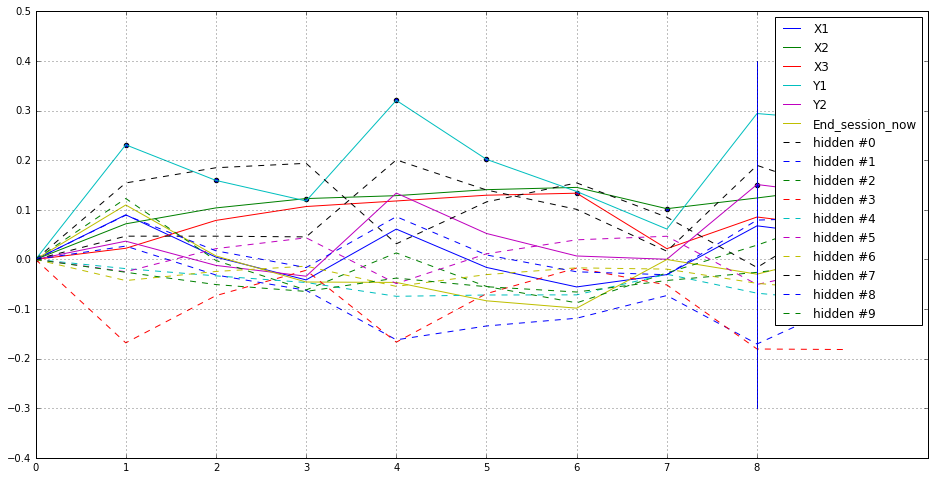

In [17]:
#visualize untrained network performance (which is mostly random)
env.generate_new_data_batch(1)
display_sessions(with_plots=True)

# Training loop

In [18]:
from agentnet.display import Metrics
score_log = Metrics()

In [19]:
#starting epoch
epoch_counter = 1

#moving average estimation
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

epoch 100,loss 9.21616, epsilon 0.96275, rewards: ( e-greedy -0.01500, greedy -0.10500) 
rec 9.204 reg 0.012
epoch 200,loss 12.41883, epsilon 0.92696, rewards: ( e-greedy -0.04850, greedy -0.28950) 
rec 12.407 reg 0.012
epoch 300,loss 8.82831, epsilon 0.89257, rewards: ( e-greedy -0.04865, greedy -0.20555) 
rec 8.816 reg 0.012
epoch 400,loss 13.66383, epsilon 0.85954, rewards: ( e-greedy -0.19878, greedy -0.06499) 
rec 13.652 reg 0.012
epoch 500,loss 8.52729, epsilon 0.82779, rewards: ( e-greedy -0.27391, greedy 0.01150) 
rec 8.515 reg 0.012
epoch 600,loss 9.94121, epsilon 0.79730, rewards: ( e-greedy -0.29152, greedy 0.12035) 
rec 9.929 reg 0.013
epoch 700,loss 10.10823, epsilon 0.76799, rewards: ( e-greedy -0.31236, greedy 0.19832) 
rec 10.095 reg 0.014
epoch 800,loss 10.64329, epsilon 0.73984, rewards: ( e-greedy -0.18613, greedy 0.41349) 
rec 10.628 reg 0.015
epoch 900,loss 8.89058, epsilon 0.71279, rewards: ( e-greedy -0.08252, greedy 0.54214) 
rec 8.874 reg 0.016
epoch 1000,loss 

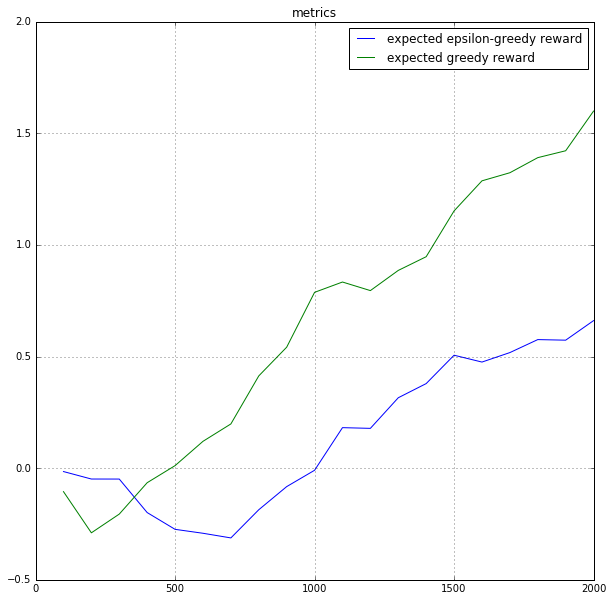

Random session examples
session # 0
 Y2(qv = 1.19185507298) -> 3.0 |  X2(qv = 0.0267684161663) -> -1.0 |  X1(qv = 0.0539692789316) -> -1.0 |  X3(qv = 0.00457841157913) -> -1.0 |  End_session_now(qv = 0.0152250379324) -> 0.0 | 



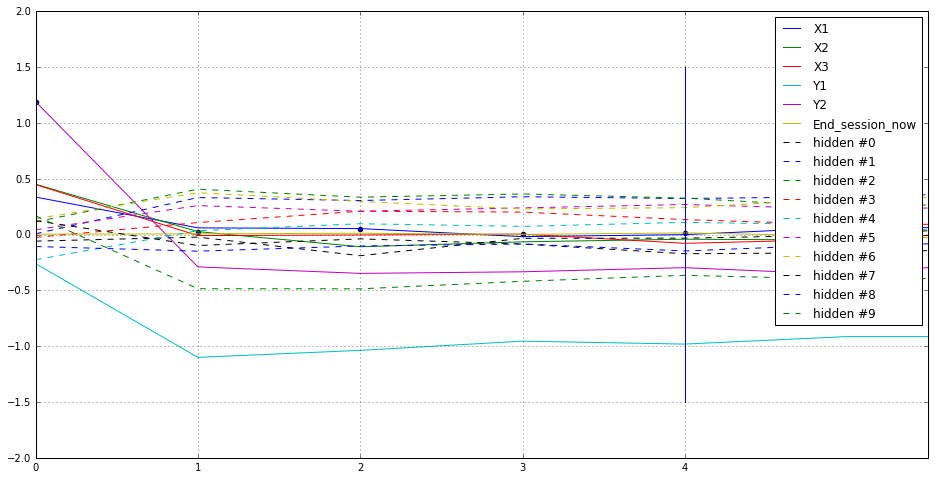

session # 1
 X1(qv = 0.336382895708) -> -1.0 |  X2(qv = 0.655502676964) -> -1.0 |  Y2(qv = 2.01617240906) -> 3.0 |  X1(qv = 0.142034858465) -> -0.5 |  X1(qv = -0.00329551100731) -> -0.5 |  End_session_now(qv = -0.00368748605251) -> 0.0 | 



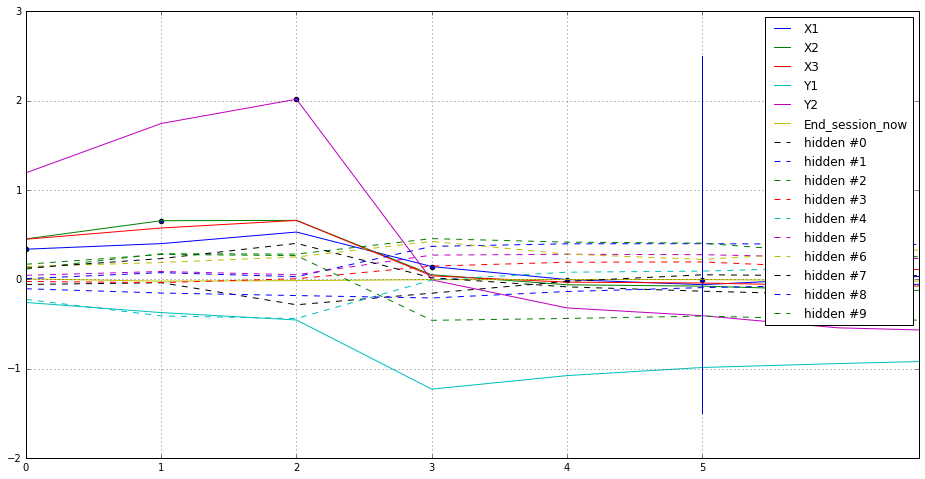

session # 2
 X3(qv = 0.448083072901) -> -1.0 |  X2(qv = 0.665745139122) -> 1.0 |  Y2(qv = 1.71770429611) -> 3.0 |  End_session_now(qv = 0.00026124343276) -> 0.0 | 



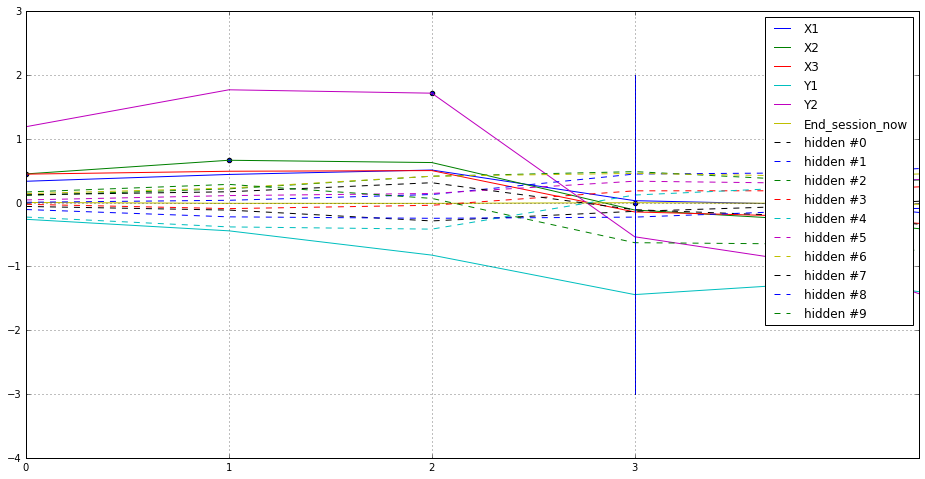

epoch 2100,loss 8.30997, epsilon 0.46012, rewards: ( e-greedy 0.62010, greedy 1.61501) 
rec 8.285 reg 0.025
epoch 2200,loss 9.28720, epsilon 0.44404, rewards: ( e-greedy 0.60809, greedy 1.64851) 
rec 9.262 reg 0.026
epoch 2300,loss 6.19368, epsilon 0.42859, rewards: ( e-greedy 0.60228, greedy 1.68366) 
rec 6.168 reg 0.026
epoch 2400,loss 9.04055, epsilon 0.41375, rewards: ( e-greedy 0.67705, greedy 1.70529) 
rec 9.014 reg 0.026
epoch 2500,loss 6.34909, epsilon 0.39949, rewards: ( e-greedy 0.71935, greedy 1.72477) 
rec 6.322 reg 0.027
epoch 2600,loss 5.94262, epsilon 0.38578, rewards: ( e-greedy 0.78741, greedy 1.81729) 
rec 5.916 reg 0.027
epoch 2700,loss 10.98318, epsilon 0.37262, rewards: ( e-greedy 0.80367, greedy 1.85056) 
rec 10.956 reg 0.027
epoch 2800,loss 7.63863, epsilon 0.35997, rewards: ( e-greedy 0.76830, greedy 1.88550) 
rec 7.611 reg 0.028
epoch 2900,loss 5.36045, epsilon 0.34781, rewards: ( e-greedy 0.87147, greedy 1.98195) 
rec 5.332 reg 0.028
epoch 3000,loss 3.20487, e

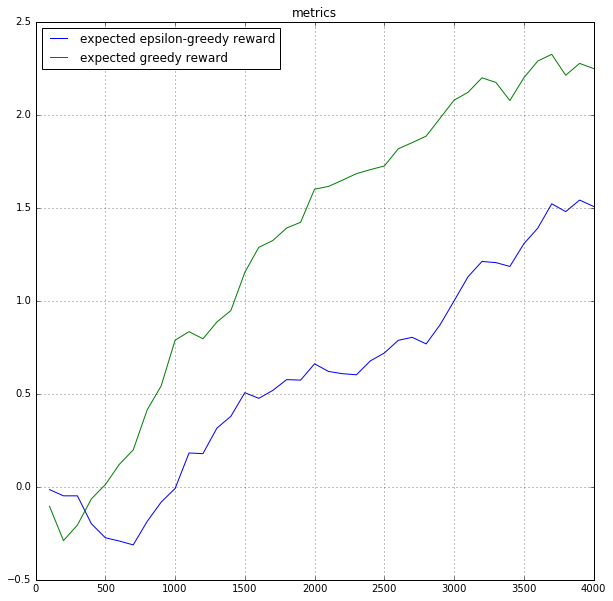

Random session examples
session # 0
 Y2(qv = 1.66768121719) -> 3.0 |  X1(qv = 0.226977214217) -> 1.0 |  End_session_now(qv = -0.00516853109002) -> 0.0 | 



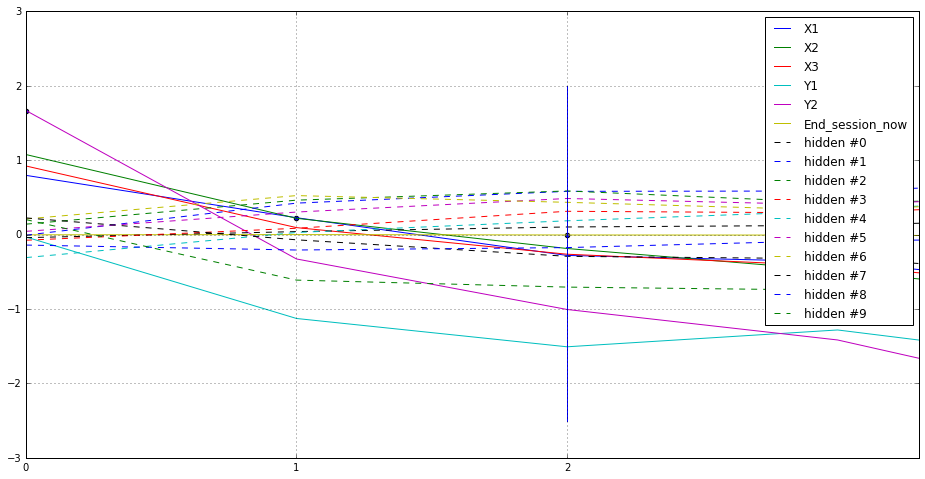

session # 1
 X1(qv = 0.796284675598) -> -1.0 |  Y2(qv = 2.28804087639) -> 3.0 |  X2(qv = 0.191758692265) -> -1.0 |  End_session_now(qv = 0.00239684805274) -> 0.0 | 



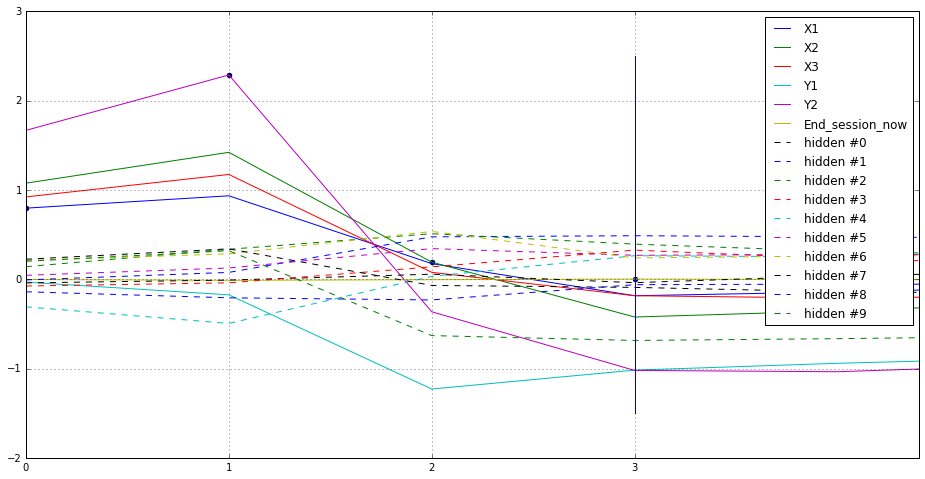

session # 2
 Y2(qv = 1.66768121719) -> 3.0 |  X1(qv = 0.226977214217) -> -1.0 |  End_session_now(qv = -0.00228424556553) -> 0.0 | 



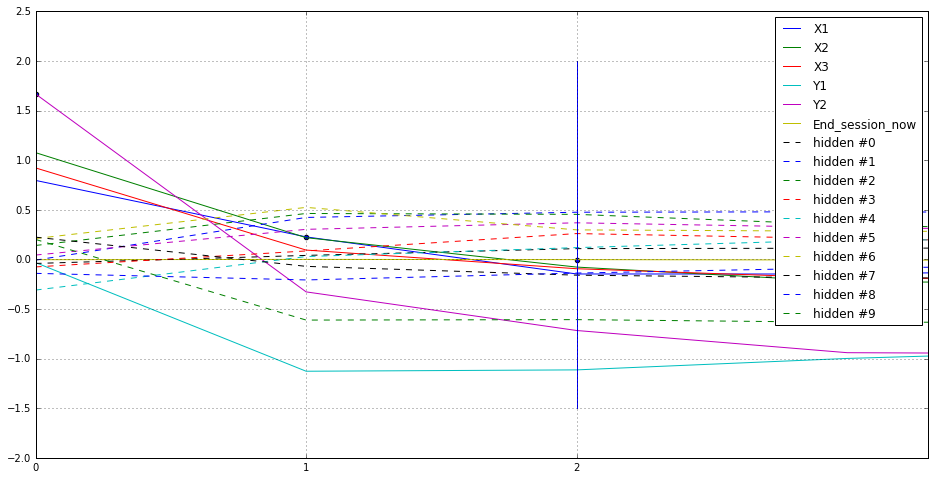

epoch 4100,loss 4.15334, epsilon 0.23428, rewards: ( e-greedy 1.54661, greedy 2.32382) 
rec 4.121 reg 0.032
epoch 4200,loss 11.32265, epsilon 0.22706, rewards: ( e-greedy 1.40695, greedy 2.16144) 
rec 11.290 reg 0.033
epoch 4300,loss 9.11441, epsilon 0.22011, rewards: ( e-greedy 1.26626, greedy 2.02529) 
rec 9.081 reg 0.033
epoch 4400,loss 6.66610, epsilon 0.21344, rewards: ( e-greedy 1.32963, greedy 2.00776) 
rec 6.633 reg 0.033
epoch 4500,loss 5.31950, epsilon 0.20703, rewards: ( e-greedy 1.41167, greedy 2.07699) 
rec 5.286 reg 0.033
epoch 4600,loss 9.21229, epsilon 0.20088, rewards: ( e-greedy 1.25550, greedy 1.96929) 
rec 9.179 reg 0.033
epoch 4700,loss 4.44721, epsilon 0.19496, rewards: ( e-greedy 1.41995, greedy 2.06236) 
rec 4.414 reg 0.034
epoch 4800,loss 12.97715, epsilon 0.18928, rewards: ( e-greedy 1.41796, greedy 1.99612) 
rec 12.943 reg 0.034
epoch 4900,loss 10.56770, epsilon 0.18382, rewards: ( e-greedy 1.31616, greedy 1.84651) 
rec 10.534 reg 0.034
epoch 5000,loss 4.1421

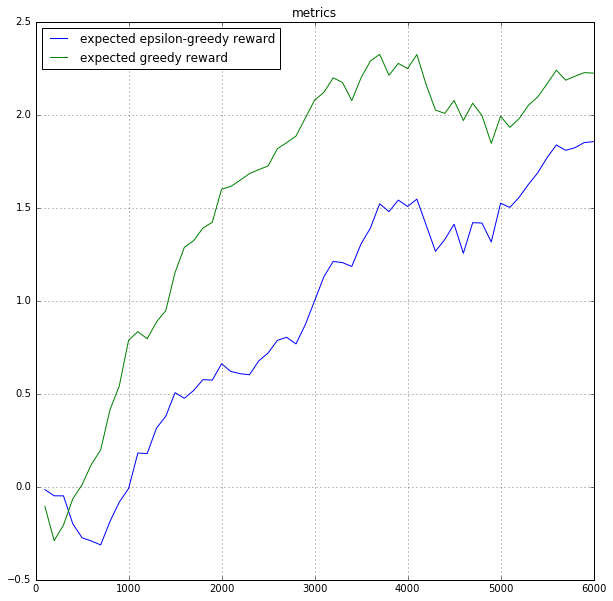

Random session examples
session # 0
 Y2(qv = 1.96957182884) -> 3.0 |  X1(qv = 0.297784596682) -> 1.0 |  End_session_now(qv = 0.000341280829161) -> 0.0 | 



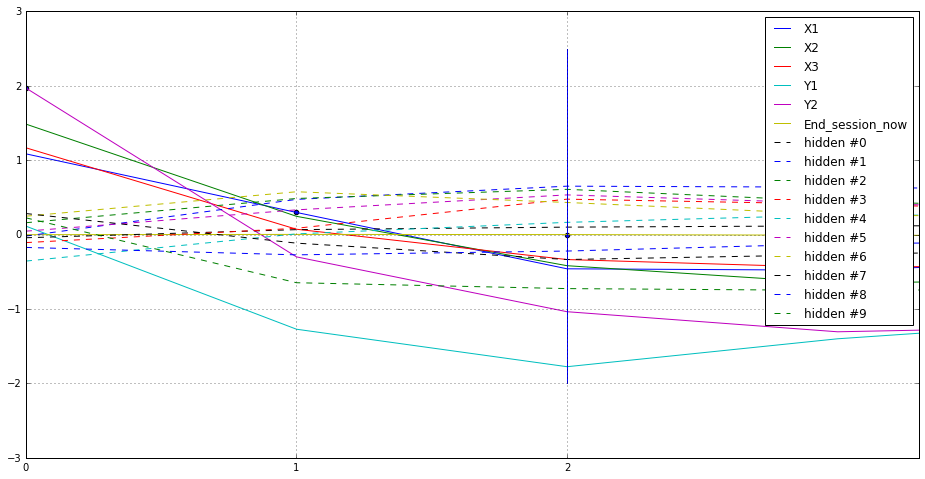

session # 1
 Y2(qv = 1.96957182884) -> 3.0 |  X1(qv = 0.297784596682) -> -1.0 |  End_session_now(qv = -0.00229620980099) -> 0.0 | 



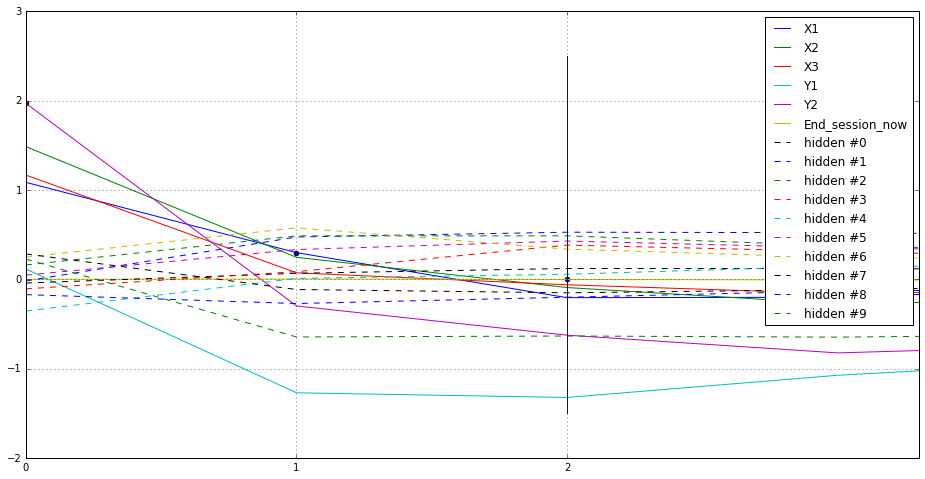

session # 2
 X2(qv = 1.48501217365) -> -1.0 |  Y2(qv = 2.31347417831) -> 3.0 |  X1(qv = 0.330569148064) -> 1.0 |  X1(qv = -0.433581352234) -> -0.5 |  End_session_now(qv = 0.00111580826342) -> 0.0 | 



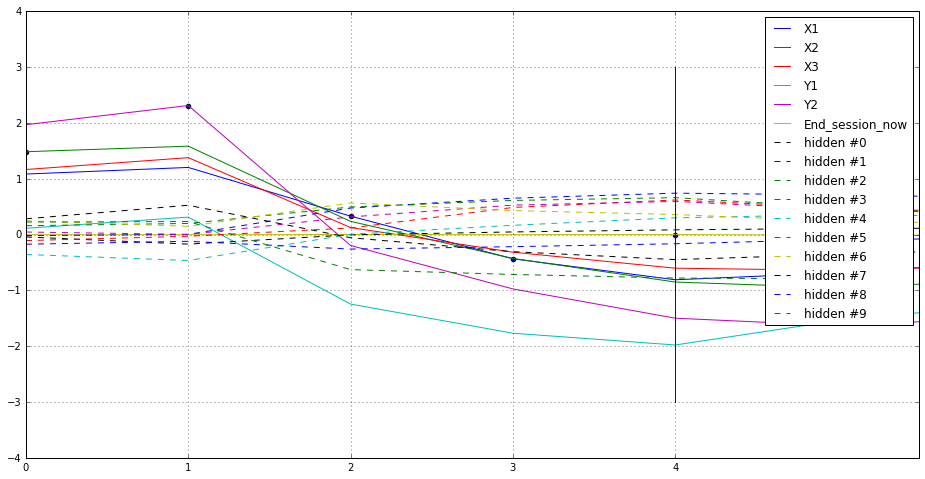

epoch 6100,loss 4.21947, epsilon 0.13280, rewards: ( e-greedy 1.88512, greedy 2.29161) 
rec 4.183 reg 0.037
epoch 6200,loss 5.49387, epsilon 0.12956, rewards: ( e-greedy 1.93661, greedy 2.34245) 
rec 5.457 reg 0.037
epoch 6300,loss 2.57494, epsilon 0.12644, rewards: ( e-greedy 2.02295, greedy 2.40820) 
rec 2.538 reg 0.037
epoch 6400,loss 2.61576, epsilon 0.12344, rewards: ( e-greedy 2.15065, greedy 2.52738) 
rec 2.579 reg 0.037
epoch 6500,loss 5.49301, epsilon 0.12056, rewards: ( e-greedy 2.11059, greedy 2.47464) 
rec 5.456 reg 0.037
epoch 6600,loss 5.51112, epsilon 0.11779, rewards: ( e-greedy 2.09953, greedy 2.42718) 
rec 5.474 reg 0.037
epoch 6700,loss 8.15476, epsilon 0.11513, rewards: ( e-greedy 1.97458, greedy 2.32446) 
rec 8.118 reg 0.037
epoch 6800,loss 6.47380, epsilon 0.11258, rewards: ( e-greedy 1.93212, greedy 2.27201) 
rec 6.437 reg 0.037
epoch 6900,loss 7.02422, epsilon 0.11013, rewards: ( e-greedy 1.91891, greedy 2.24481) 
rec 6.987 reg 0.037
epoch 7000,loss 6.88206, eps

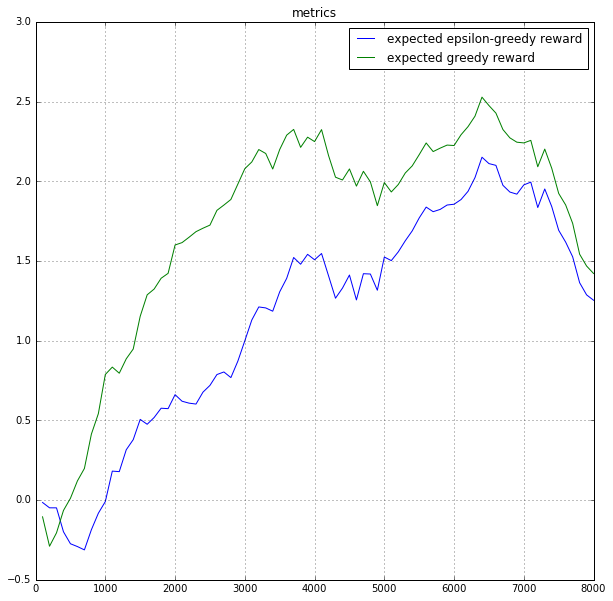

Random session examples
session # 0
 Y1(qv = 0.20185855031) -> 3.0 |  Y2(qv = 1.25026798248) -> -3.0 |  X2(qv = 0.289733767509) -> 1.0 |  End_session_now(qv = 0.000178101938218) -> 0.0 | 



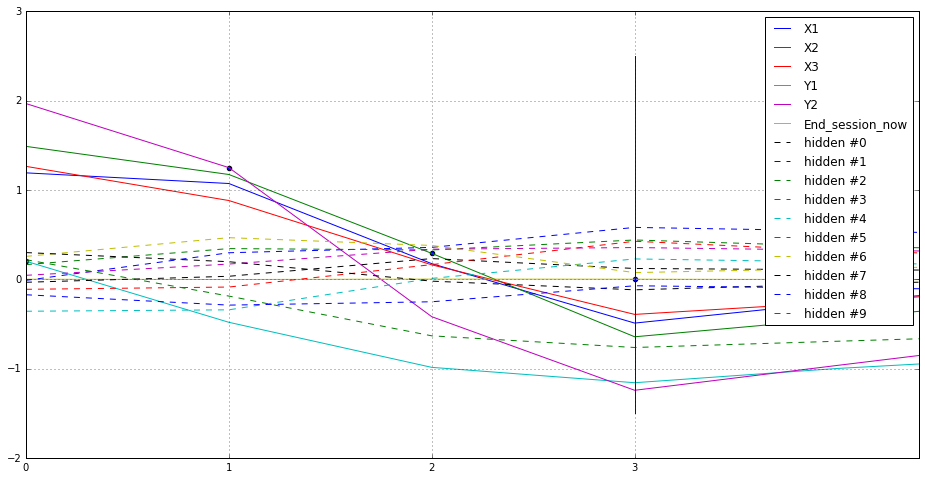

session # 1
 Y2(qv = 1.96774613857) -> 3.0 |  X1(qv = 0.302861511707) -> -1.0 |  End_session_now(qv = -0.00114921899512) -> 0.0 | 



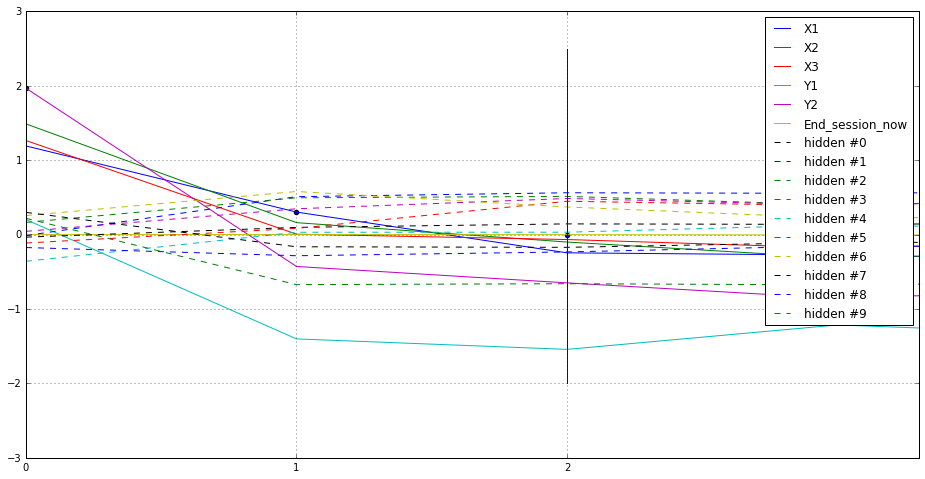

session # 2
 Y2(qv = 1.96774601936) -> 3.0 |  X1(qv = 0.302861511707) -> 1.0 |  End_session_now(qv = 0.000396818853915) -> 0.0 | 



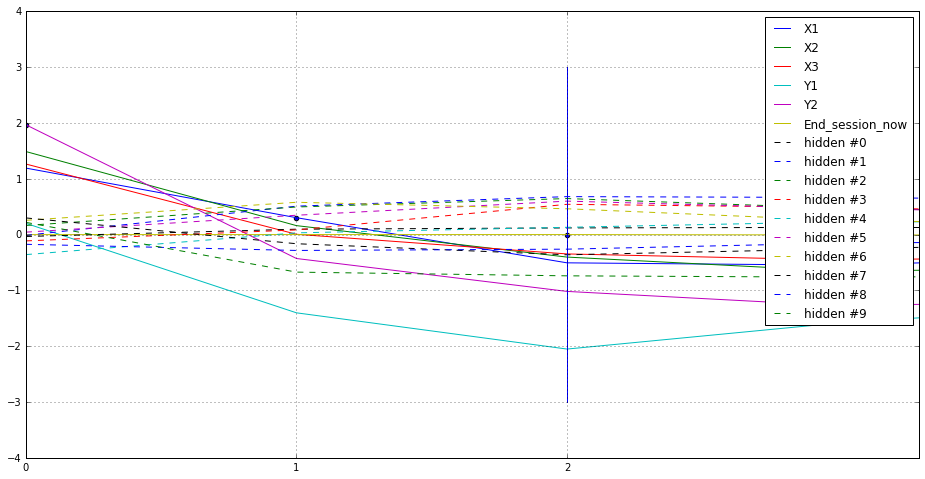

epoch 8100,loss 8.78552, epsilon 0.08721, rewards: ( e-greedy 1.32310, greedy 1.44912) 
rec 8.748 reg 0.038
epoch 8200,loss 7.27668, epsilon 0.08575, rewards: ( e-greedy 1.37079, greedy 1.47421) 
rec 7.239 reg 0.038
epoch 8300,loss 7.44188, epsilon 0.08435, rewards: ( e-greedy 1.30871, greedy 1.44679) 
rec 7.404 reg 0.038
epoch 8400,loss 5.29253, epsilon 0.08300, rewards: ( e-greedy 1.41784, greedy 1.54211) 
rec 5.255 reg 0.038
epoch 8500,loss 8.05373, epsilon 0.08170, rewards: ( e-greedy 1.39606, greedy 1.50790) 
rec 8.016 reg 0.038
epoch 8600,loss 2.69886, epsilon 0.08046, rewards: ( e-greedy 1.50645, greedy 1.61711) 
rec 2.661 reg 0.038
epoch 8700,loss 5.39137, epsilon 0.07927, rewards: ( e-greedy 1.59581, greedy 1.67540) 
rec 5.354 reg 0.038
epoch 8800,loss 6.35112, epsilon 0.07812, rewards: ( e-greedy 1.59623, greedy 1.68786) 
rec 6.313 reg 0.038
epoch 8900,loss 5.27824, epsilon 0.07702, rewards: ( e-greedy 1.61660, greedy 1.73907) 
rec 5.241 reg 0.038
epoch 9000,loss 5.43956, eps

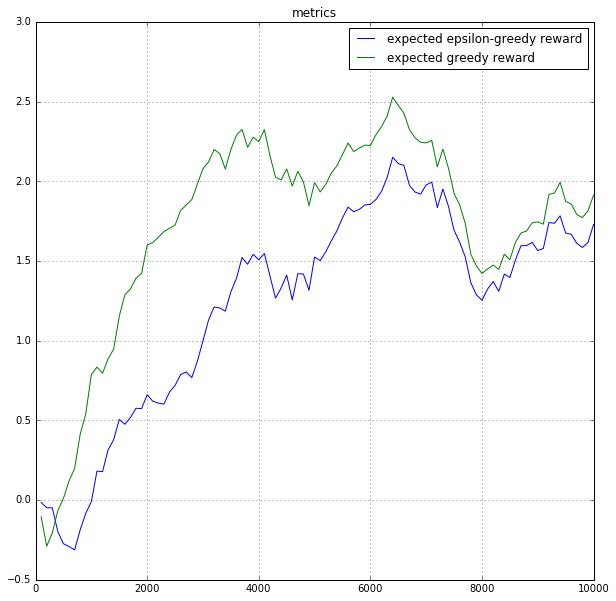

Random session examples
session # 0
 Y2(qv = 1.99424099922) -> 3.0 |  X1(qv = 0.333094418049) -> -1.0 |  End_session_now(qv = -0.000473402906209) -> 0.0 | 



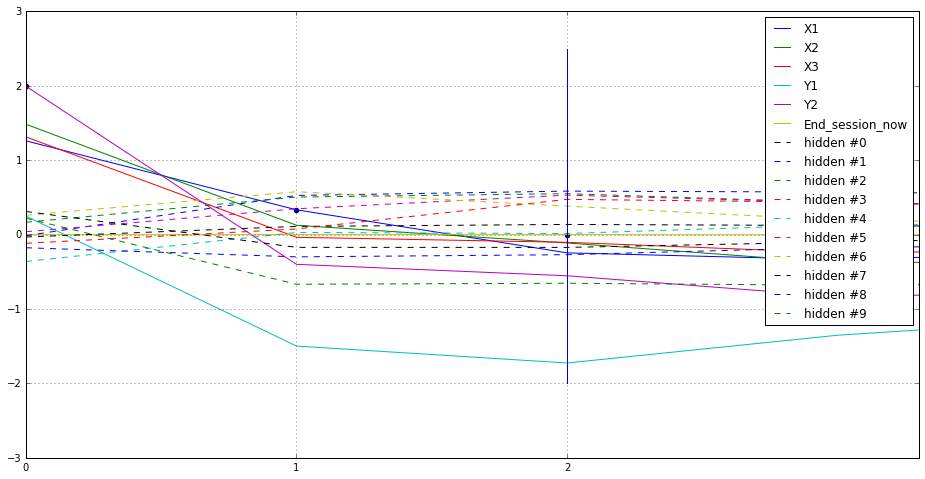

session # 1
 Y2(qv = 1.99424099922) -> 3.0 |  X1(qv = 0.333094418049) -> -1.0 |  End_session_now(qv = -0.000473402906209) -> 0.0 | 



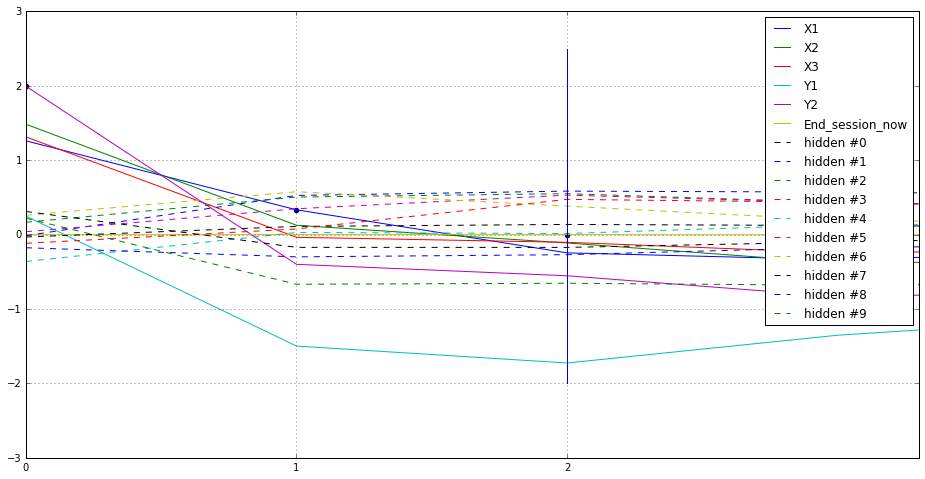

session # 2
 Y2(qv = 1.99424099922) -> -3.0 |  X2(qv = 1.02034783363) -> 1.0 |  End_session_now(qv = 0.000271528493613) -> 0.0 | 



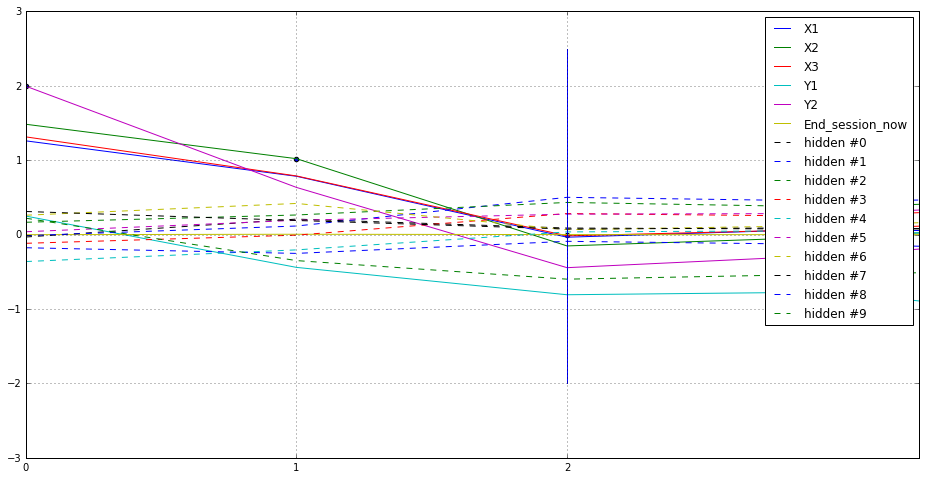

In [20]:
n_epochs = 10000
batch_size=10

for i in range(n_epochs):    
    
    #train
    env.generate_new_data_batch(batch_size)
    loss,avg_reward = train_fun()
    
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%10 ==0:
        current_epsilon =  0.05 + 0.95*np.exp(-epoch_counter/2500.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##show current learning progress
    if epoch_counter%100 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected epsilon-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))

        print "epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,l2_penalty)

        
    #visualize learning curve and sample sessions
    if epoch_counter %2000 ==0:
        print "Learning curves:"
        score_log.plot()
        
        print "Random session examples"
        env.generate_new_data_batch(3)
        display_sessions(with_plots=True)



        
        
    epoch_counter  +=1


# Evaluate results

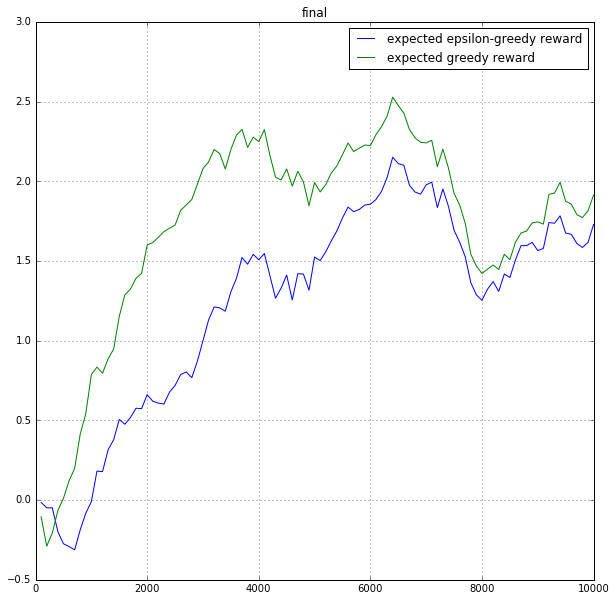

In [21]:
score_log.plot("final")

Random session examples
session # 0
 Y2(qv = 1.99424099922) -> 3.0 |  X1(qv = 0.333094447851) -> 1.0 |  End_session_now(qv = 0.000314842443913) -> 0.0 | 



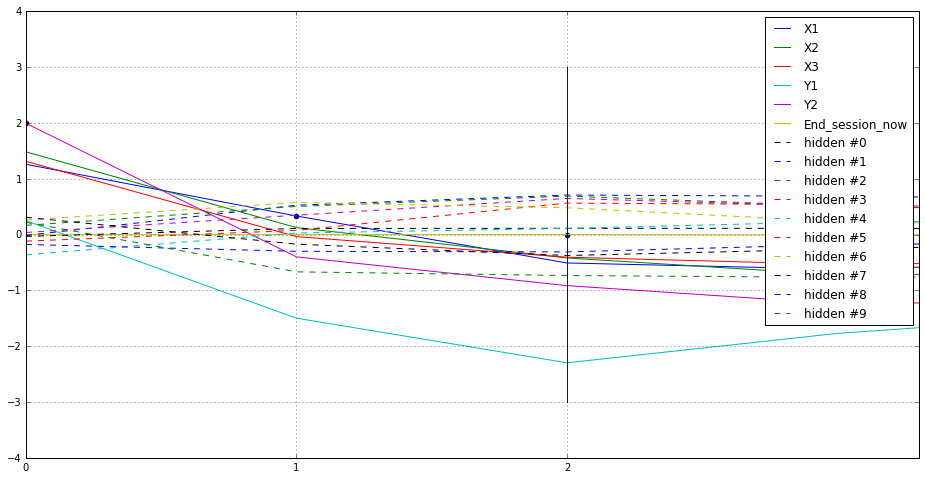

session # 1
 Y2(qv = 1.99424099922) -> 3.0 |  X1(qv = 0.333094447851) -> 1.0 |  End_session_now(qv = 0.000314842443913) -> 0.0 | 



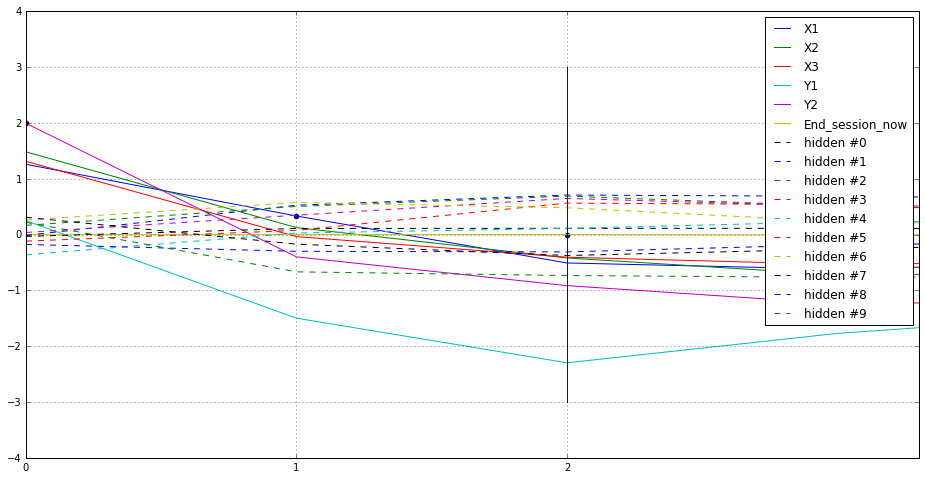

session # 2
 Y2(qv = 1.99424099922) -> 3.0 |  X1(qv = 0.333094447851) -> -1.0 |  End_session_now(qv = -0.000473402906209) -> 0.0 | 



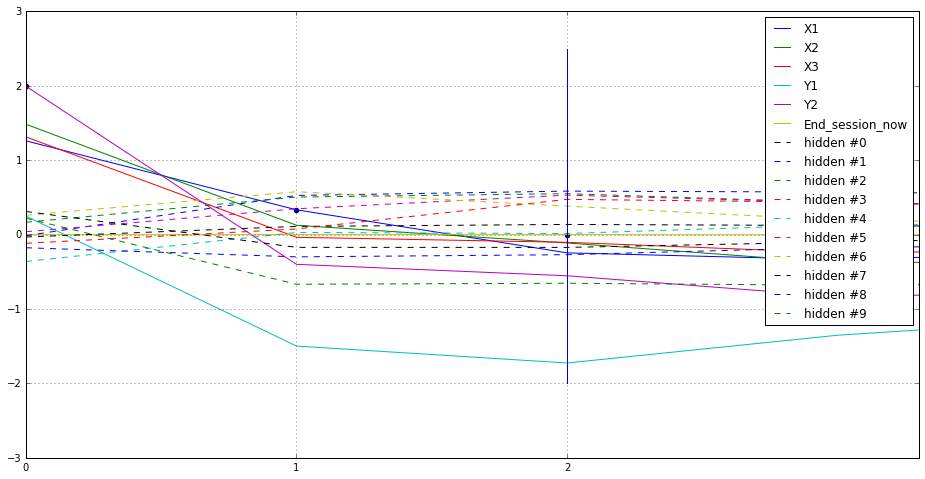

session # 3
 Y2(qv = 1.99424099922) -> 3.0 |  X1(qv = 0.333094447851) -> 1.0 |  End_session_now(qv = 0.000314842443913) -> 0.0 | 



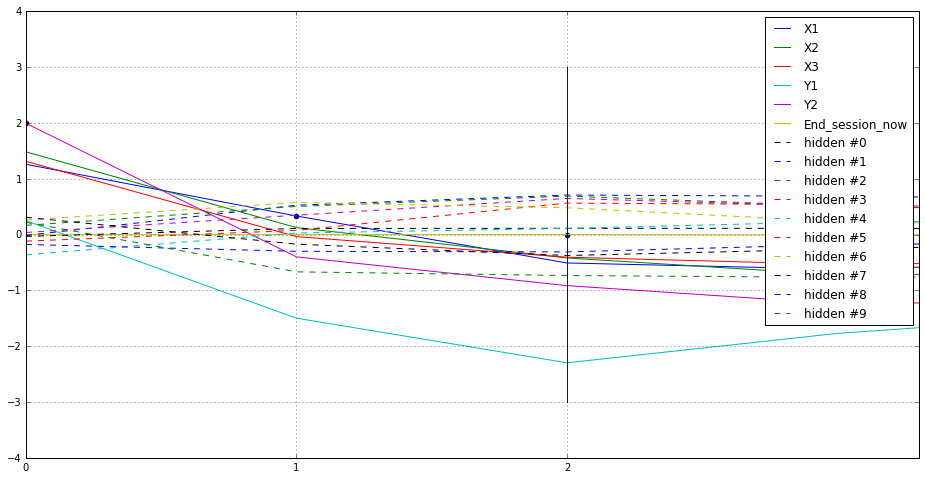

session # 4
 Y2(qv = 1.99424099922) -> 3.0 |  X1(qv = 0.333094447851) -> -1.0 |  End_session_now(qv = -0.000473402906209) -> 0.0 | 



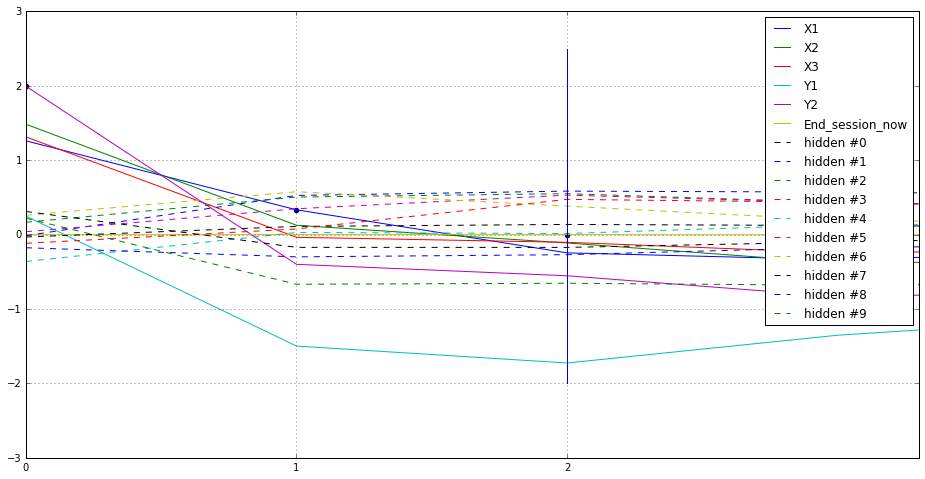

session # 5
 Y2(qv = 1.99424099922) -> 3.0 |  X1(qv = 0.333094447851) -> 1.0 |  End_session_now(qv = 0.000314842443913) -> 0.0 | 



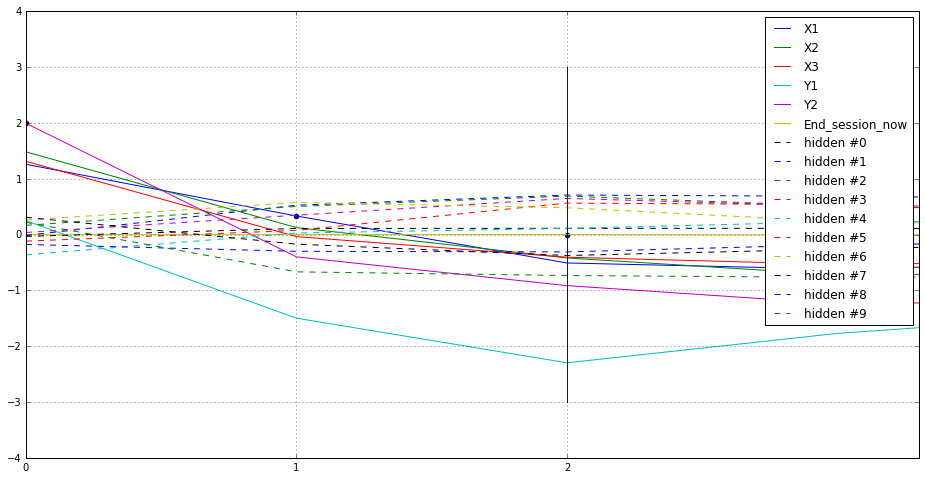

session # 6
 Y2(qv = 1.99424099922) -> -3.0 |  X2(qv = 1.02034771442) -> 1.0 |  End_session_now(qv = 0.000271528493613) -> 0.0 | 



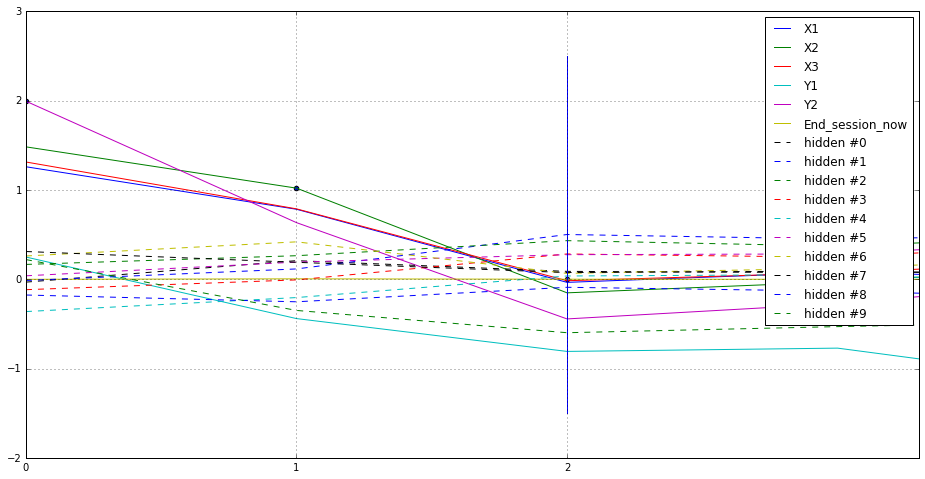

session # 7
 Y2(qv = 1.99424099922) -> 3.0 |  X1(qv = 0.333094447851) -> 1.0 |  End_session_now(qv = 0.000314842443913) -> 0.0 | 



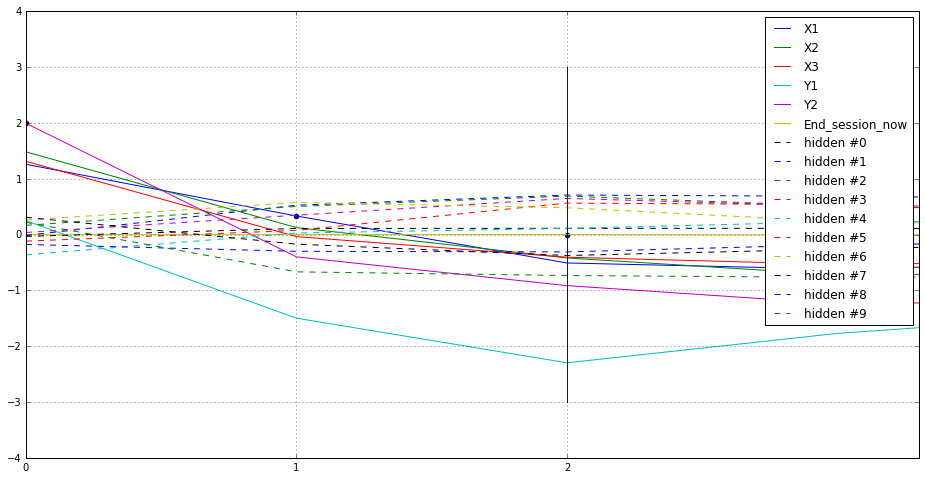

session # 8
 Y2(qv = 1.99424099922) -> 3.0 |  X1(qv = 0.333094418049) -> 1.0 |  End_session_now(qv = 0.000314842443913) -> 0.0 | 



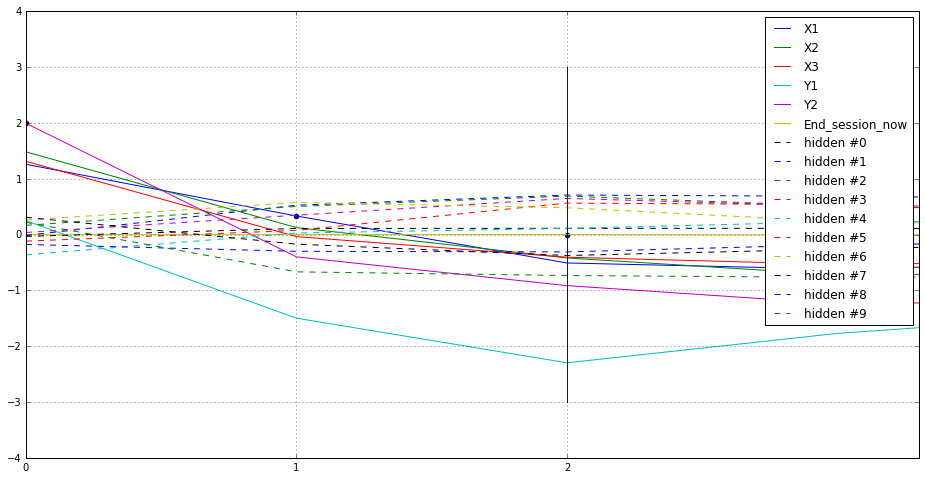

session # 9
 Y2(qv = 1.99424099922) -> 3.0 |  X1(qv = 0.333094418049) -> 1.0 |  End_session_now(qv = 0.000314842443913) -> 0.0 | 



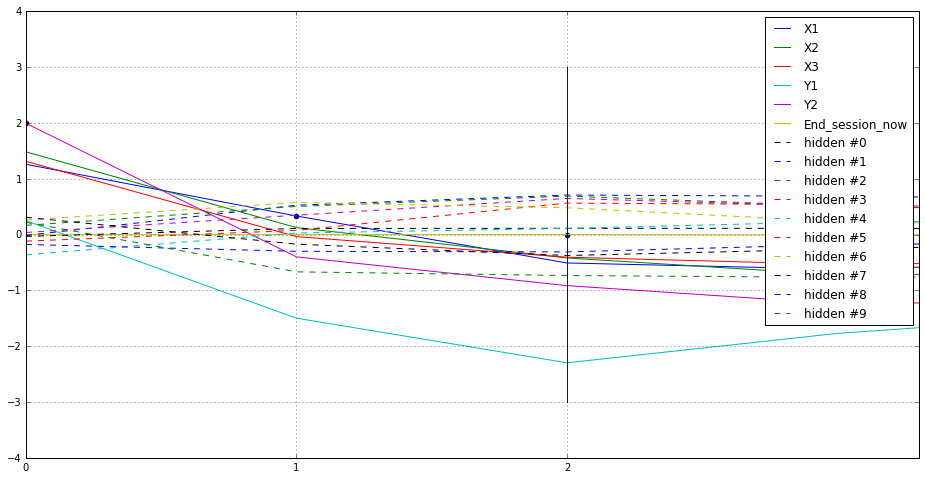

In [22]:
resolver.epsilon.set_value(np.float32(0.))
print "Random session examples"
env.generate_new_data_batch(10)
display_sessions(with_plots=True)
